In [1]:
# Installation
!pip install networkx python-louvain scikit-learn pandas numpy matplotlib seaborn scipy

In [3]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from scipy import stats
from scipy.spatial.distance import cdist, pdist, squareform

# For community detection
try:
    import community as community_louvain
    print("python-louvain installed")
except ImportError:
    print("Installing python-louvain")
    !pip install python-louvain
    import community as community_louvain

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# For reproducibility
np.random

python-louvain installed


<module 'numpy.random' from '/usr/local/lib/python3.12/dist-packages/numpy/random/__init__.py'>

Create Realistic Synthetic Connectome

In [4]:
def create_synthetic_connectome(n_neurons=500, n_communities=5):
    """
    Create biologically-plausible synthetic connectome
    with spatial structure and community organization
    """
    # Generate neurons with spatial coordinates
    neuron_positions = np.random.rand(n_neurons, 3) * 100  # 100μm cube

    # Assign neurons to communities
    community_assignment = np.random.randint(0, n_communities, n_neurons)

    # Build network with distance-dependent connectivity
    G = nx.DiGraph()

    # Add neurons as nodes with attributes
    for i in range(n_neurons):
        G.add_node(i,
                   pos=neuron_positions[i],
                   community=community_assignment[i])

    # Add edges based on:
    # 1. Distance (closer neurons more likely to connect)
    # 2. Community (same community more likely to connect)

    from scipy.spatial.distance import cdist
    distances = cdist(neuron_positions, neuron_positions)

    for i in range(n_neurons):
        for j in range(n_neurons):
            if i == j:
                continue

            # Probability based on distance
            dist = distances[i, j]
            p_dist = np.exp(-dist / 20)  # 20μm length constant

            # Probability boost if same community
            same_community = community_assignment[i] == community_assignment[j]
            p_community = 0.3 if same_community else 0.1

            # Combined probability
            p_connect = p_dist * p_community

            if np.random.rand() < p_connect:
                weight = np.random.lognormal(0, 0.5)  # Synaptic strength
                G.add_edge(i, j, weight=weight)

    return G, neuron_positions, community_assignment

# Create synthetic data
G, positions, true_communities = create_synthetic_connectome(n_neurons=500)

print(f"Created connectome: {G.number_of_nodes()} neurons, {G.number_of_edges()} synapses")

Created connectome: 500 neurons, 2525 synapses


Network Statistics

In [5]:
# Basic network metrics
def analyze_network_properties(G):
    """
    Compute key network statistics
    """
    results = {
        'n_nodes': G.number_of_nodes(),
        'n_edges': G.number_of_edges(),
        'density': nx.density(G),
        'avg_in_degree': np.mean([d for n, d in G.in_degree()]),
        'avg_out_degree': np.mean([d for n, d in G.out_degree()]),
    }

    # Connected components
    weak_components = list(nx.weakly_connected_components(G))
    results['n_weak_components'] = len(weak_components)
    results['largest_component_size'] = len(max(weak_components, key=len))

    # Clustering (on undirected version)
    G_undirected = G.to_undirected()
    results['avg_clustering'] = nx.average_clustering(G_undirected)

    return results

props = analyze_network_properties(G)
for key, val in props.items():
    print(f"{key}: {val:.4f}" if isinstance(val, float) else f"{key}: {val}")

n_nodes: 500
n_edges: 2525
density: 0.0101
avg_in_degree: 5.0500
avg_out_degree: 5.0500
n_weak_components: 1
largest_component_size: 500
avg_clustering: 0.0375


Community detection

Modularity: 0.3771
Number of communities: 14
Community sizes: [33, 23, 31, 36, 63, 42, 41, 35, 35, 44, 26, 42, 27, 22]
Adjusted Rand Index: 0.0177


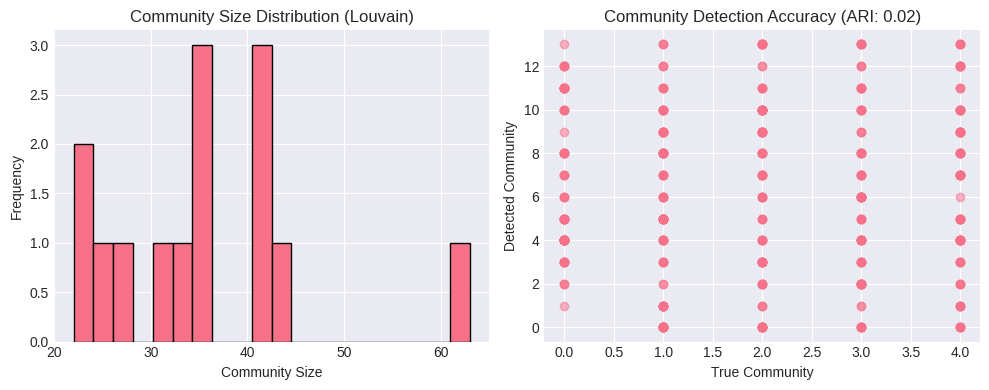

In [6]:
# METHOD 1: Modularity Maximization (Louvain)
def detect_communities_louvain(G):
    """
    Detect communities using Louvain algorithm (modularity maximization)
    """
    # Convert to undirected for community detection
    G_undirected = G.to_undirected()

    # Detect communities
    communities = community_louvain.best_partition(G_undirected)

    # Calculate modularity
    modularity = community_louvain.modularity(communities, G_undirected)

    # Organize results
    community_dict = {}
    for node, comm_id in communities.items():
        if comm_id not in community_dict:
            community_dict[comm_id] = []
        community_dict[comm_id].append(node)

    return communities, modularity, community_dict

communities_louvain, modularity, community_dict = detect_communities_louvain(G)

print(f"Modularity: {modularity:.4f}")
print(f"Number of communities: {len(community_dict)}")
print(f"Community sizes: {[len(nodes) for nodes in community_dict.values()]}")

# Visualize community size distribution
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sizes = [len(nodes) for nodes in community_dict.values()]
plt.hist(sizes, bins=20, edgecolor='black')
plt.xlabel('Community Size')
plt.ylabel('Frequency')
plt.title('Community Size Distribution (Louvain)')

plt.subplot(1, 2, 2)
# Compare to ground truth if using synthetic data
if 'true_communities' in globals():
    from sklearn.metrics import adjusted_rand_score
    detected = [communities_louvain[i] for i in range(len(true_communities))]
    ari = adjusted_rand_score(true_communities, detected)
    print(f"Adjusted Rand Index: {ari:.4f}")

    plt.scatter(true_communities, detected, alpha=0.5)
    plt.xlabel('True Community')
    plt.ylabel('Detected Community')
    plt.title(f'Community Detection Accuracy (ARI: {ari:.2f})')

plt.tight_layout()
plt.savefig('community_detection_louvain.png', dpi=300, bbox_inches='tight')
plt.show()

Spatial Analysis of Synapses

In [7]:
# Extract synapse positions (connection midpoints or target positions)
def extract_synapse_positions(G):
    """
    Extract spatial coordinates of synapses
    For each edge (synapse), use target neuron position
    """
    synapse_coords = []
    synapse_info = []

    for source, target in G.edges():
        target_pos = G.nodes[target]['pos']
        synapse_coords.append(target_pos)
        synapse_info.append({
            'source': source,
            'target': target,
            'pos': target_pos
        })

    return np.array(synapse_coords), synapse_info

synapse_coords, synapse_info = extract_synapse_positions(G)
print(f"Analyzing {len(synapse_coords)} synapses in 3D space")

Analyzing 2525 synapses in 3D space


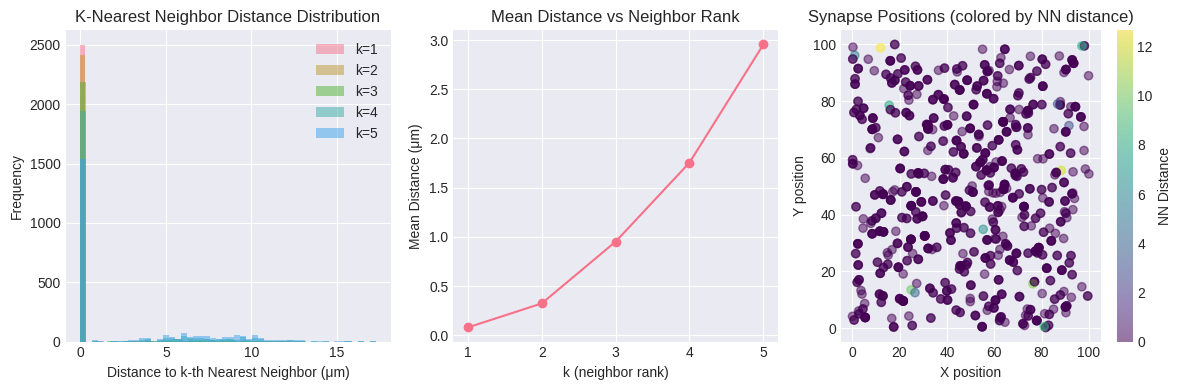

In [8]:
# K-NEAREST NEIGHBOR ANALYSIS
def knn_spatial_analysis(coords, k=5):
    """
    Analyze spatial distribution using K-nearest neighbors
    """
    # Fit KNN
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(coords)
    distances, indices = nbrs.kneighbors(coords)

    # Exclude self (first column)
    nn_distances = distances[:, 1:]

    # Statistics
    results = {
        'mean_nn_dist': np.mean(nn_distances, axis=0),
        'std_nn_dist': np.std(nn_distances, axis=0),
        'median_nn_dist': np.median(nn_distances, axis=0),
        'all_distances': nn_distances
    }

    return results, nn_distances

knn_results, nn_distances = knn_spatial_analysis(synapse_coords, k=5)

# Visualize NN distance distribution
plt.figure(figsize=(12, 4))

for k_idx in range(5):
    plt.subplot(1, 3, 1)
    plt.hist(nn_distances[:, k_idx], bins=50, alpha=0.5,
             label=f'k={k_idx+1}')

plt.xlabel('Distance to k-th Nearest Neighbor (μm)')
plt.ylabel('Frequency')
plt.legend()
plt.title('K-Nearest Neighbor Distance Distribution')

# Plot mean vs k
plt.subplot(1, 3, 2)
plt.plot(range(1, 6), knn_results['mean_nn_dist'], 'o-')
plt.xlabel('k (neighbor rank)')
plt.ylabel('Mean Distance (μm)')
plt.title('Mean Distance vs Neighbor Rank')

# 3D scatter of synapses (sample)
plt.subplot(1, 3, 3)
sample_idx = np.random.choice(len(synapse_coords), 1000, replace=False)
plt.scatter(synapse_coords[sample_idx, 0],
           synapse_coords[sample_idx, 1],
           c=nn_distances[sample_idx, 0],
           cmap='viridis', alpha=0.5)
plt.colorbar(label='NN Distance')
plt.xlabel('X position')
plt.ylabel('Y position')
plt.title('Synapse Positions (colored by NN distance)')

plt.tight_layout()
plt.savefig('knn_spatial_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
# HOPKINS STATISTIC - Test for spatial randomness
def hopkins_statistic(X, n_samples=200):
    """
    Hopkins statistic for spatial clustering
    H > 0.5: clustered
    H ~ 0.5: random
    H < 0.5: regular/dispersed
    """
    n_samples = min(n_samples, len(X) // 10)

    # Sample random points in same volume
    mins = X.min(axis=0)
    maxs = X.max(axis=0)
    random_points = np.random.uniform(mins, maxs, (n_samples, X.shape[1]))

    # Distance from random points to nearest data point
    nbrs = NearestNeighbors(n_neighbors=1).fit(X)
    u_distances, _ = nbrs.kneighbors(random_points)

    # Distance from data samples to nearest neighbor
    sample_indices = np.random.choice(len(X), n_samples, replace=False)
    X_sample = X[sample_indices]
    v_distances, _ = nbrs.kneighbors(X_sample, n_neighbors=2)
    v_distances = v_distances[:, 1]  # Exclude self

    # Hopkins statistic
    H = np.sum(u_distances) / (np.sum(u_distances) + np.sum(v_distances))

    return H

hopkins = hopkins_statistic(synapse_coords)
print(f"\nHopkins Statistic: {hopkins:.4f}")
if hopkins > 0.7:
    print("→ Strong clustering detected")
elif hopkins > 0.55:
    print("→ Moderate clustering")
elif hopkins > 0.45:
    print("→ Approximately random distribution")
else:
    print("→ Regular/dispersed distribution")


Hopkins Statistic: 0.9947
→ Strong clustering detected


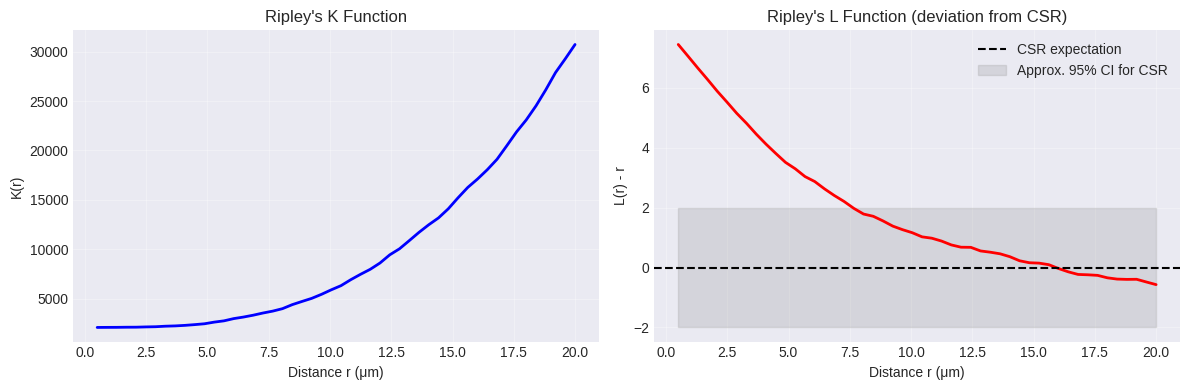

L(r) - r values: [7.44428434 7.05417757 6.66013879 6.2778227  5.88454449 5.52035926
 5.14668043 4.81313975 4.4516963  4.11806129]


In [10]:
# RIPLEY'S K FUNCTION
def ripleys_k_3d(coords, radii, volume=None):
    """
    Ripley's K function for 3D point patterns
    """
    n = len(coords)

    if volume is None:
        # Estimate volume from bounding box
        volume = np.prod(coords.max(axis=0) - coords.min(axis=0))

    from scipy.spatial.distance import pdist, squareform
    dist_matrix = squareform(pdist(coords))

    k_values = []
    for r in radii:
        # Count pairs within distance r
        pairs_within_r = np.sum(dist_matrix <= r) - n  # Exclude diagonal

        # K(r) = (volume * pairs) / (n * (n-1))
        k = (volume * pairs_within_r) / (n * (n - 1))
        k_values.append(k)

    return np.array(k_values)

# Compute Ripley's K
radii = np.linspace(0.5, 20, 50)
k_values = ripleys_k_3d(synapse_coords, radii)

# L-function (variance-stabilized version)
# Under CSR: L(r) ≈ r
l_values = (k_values * 3 / (4 * np.pi)) ** (1/3)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(radii, k_values, 'b-', linewidth=2)
plt.xlabel('Distance r (μm)')
plt.ylabel('K(r)')
plt.title("Ripley's K Function")
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(radii, l_values - radii, 'r-', linewidth=2)
plt.axhline(0, color='black', linestyle='--', label='CSR expectation')
plt.fill_between(radii, -2, 2, alpha=0.2, color='gray',
                 label='Approx. 95% CI for CSR')
plt.xlabel('Distance r (μm)')
plt.ylabel('L(r) - r')
plt.title("Ripley's L Function (deviation from CSR)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ripleys_function.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"L(r) - r values: {(l_values - radii)[:10]}")

Compare Spatial Distributions Across Communities


Spatial Distribution by Community:
    Community  N_Synapses  Mean_NN_Dist  Hopkins_Stat
1           1         115      7.594591      0.777683
7           3         181      6.474703      0.740374
12          2         162      6.222915      0.715318
4           4         348      3.824735      0.684919
5           5         198      5.338463      0.666238
13         12         113      9.299240      0.660798
8           9         167      7.006097      0.660727
9          10         200      5.978760      0.651195
11          0         197      5.571157      0.648887
0          11         141      7.936921      0.609428
3           7         174      6.385233      0.594311
10         13         156      6.875611      0.590637
6           8         232      5.337476      0.589516
2           6         141      7.460006      0.545868


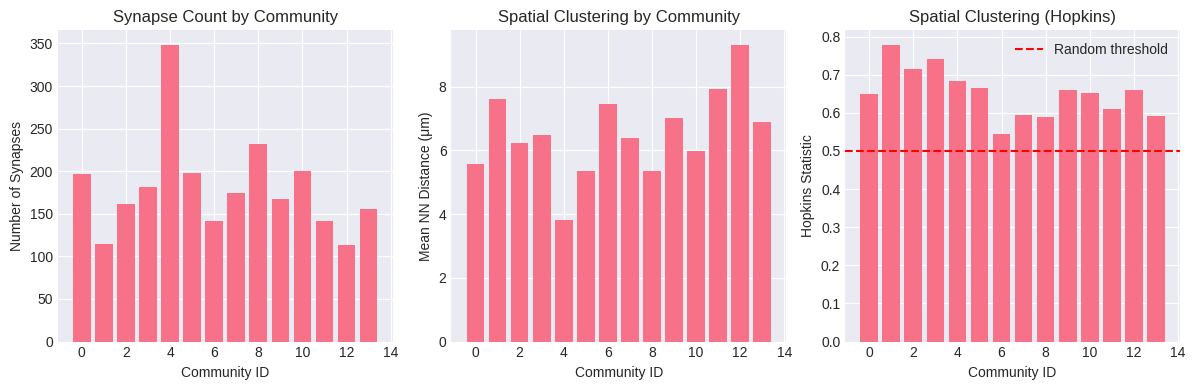

In [11]:
def compare_community_spatial_distributions(G, communities):
    """
    Compare spatial distributions of synapses across communities
    """
    # Group synapses by source community
    community_synapses = {}

    for source, target in G.edges():
        comm = communities[source]
        if comm not in community_synapses:
            community_synapses[comm] = []
        community_synapses[comm].append(G.nodes[target]['pos'])

    # Analyze each community
    results = {}
    for comm_id, coords in community_synapses.items():
        if len(coords) < 10:  # Skip small communities
            continue

        coords = np.array(coords)

        # KNN analysis
        knn_res, _ = knn_spatial_analysis(coords, k=3)

        # Hopkins statistic
        hopkins = hopkins_statistic(coords)

        results[comm_id] = {
            'n_synapses': len(coords),
            'mean_nn_dist': knn_res['mean_nn_dist'][0],
            'hopkins': hopkins,
            'centroid': coords.mean(axis=0)
        }

    return results, community_synapses

community_spatial = compare_community_spatial_distributions(G, communities_louvain)
spatial_results, community_synapses = community_spatial

# Create comparison dataframe
comparison_data = []
for comm_id, stats in spatial_results.items():
    comparison_data.append({
        'Community': comm_id,
        'N_Synapses': stats['n_synapses'],
        'Mean_NN_Dist': stats['mean_nn_dist'],
        'Hopkins_Stat': stats['hopkins']
    })

df_comparison = pd.DataFrame(comparison_data)
print("\nSpatial Distribution by Community:")
print(df_comparison.sort_values('Hopkins_Stat', ascending=False))

# Visualize
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.bar(df_comparison['Community'], df_comparison['N_Synapses'])
plt.xlabel('Community ID')
plt.ylabel('Number of Synapses')
plt.title('Synapse Count by Community')

plt.subplot(1, 3, 2)
plt.bar(df_comparison['Community'], df_comparison['Mean_NN_Dist'])
plt.xlabel('Community ID')
plt.ylabel('Mean NN Distance (μm)')
plt.title('Spatial Clustering by Community')

plt.subplot(1, 3, 3)
plt.bar(df_comparison['Community'], df_comparison['Hopkins_Stat'])
plt.axhline(0.5, color='red', linestyle='--', label='Random threshold')
plt.xlabel('Community ID')
plt.ylabel('Hopkins Statistic')
plt.title('Spatial Clustering (Hopkins)')
plt.legend()

plt.tight_layout()
plt.savefig('community_spatial_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

Key Findings Summary

In [12]:
# Create summary report
print("CONNECTOME ANALYSIS SUMMARY")

print(f"\nNETWORK PROPERTIES:")
print(f"  • Neurons: {G.number_of_nodes()}")
print(f"  • Synapses: {G.number_of_edges()}")
print(f"  • Network density: {nx.density(G):.4f}")
print(f"  • Average clustering: {props['avg_clustering']:.4f}")

print(f"\nCOMMUNITY STRUCTURE:")
print(f"  • Louvain modularity: {modularity:.4f}")
print(f"  • Number of communities: {len(community_dict)}")
print(f"  • Largest community: {max([len(nodes) for nodes in community_dict.values()])} neurons")

print(f"\nSPATIAL ORGANIZATION:")
print(f"  • Hopkins statistic: {hopkins:.4f}")
if hopkins > 0.55:
    print(f"  Synapses show CLUSTERED distribution")
else:
    print(f"  Synapses show RANDOM distribution")
print(f"  • Mean NN distance: {knn_results['mean_nn_dist'][0]:.2f} μm")

print(f"\nKEY INSIGHTS:")
print(f"  • Communities vary in spatial clustering (Hopkins: {df_comparison['Hopkins_Stat'].min():.2f} - {df_comparison['Hopkins_Stat'].max():.2f})")
print(f"  • Modularity indicates {'strong' if modularity > 0.4 else 'moderate'} community structure")

CONNECTOME ANALYSIS SUMMARY

NETWORK PROPERTIES:
  • Neurons: 500
  • Synapses: 2525
  • Network density: 0.0101
  • Average clustering: 0.0375

COMMUNITY STRUCTURE:
  • Louvain modularity: 0.3771
  • Number of communities: 14
  • Largest community: 63 neurons

SPATIAL ORGANIZATION:
  • Hopkins statistic: 0.9947
  Synapses show CLUSTERED distribution
  • Mean NN distance: 0.08 μm

KEY INSIGHTS:
  • Communities vary in spatial clustering (Hopkins: 0.55 - 0.78)
  • Modularity indicates moderate community structure
